## Authors of the Notebook: 
- Christopher Lim 
- Nathan Von Rodriguez  

Section: S12  
## Task Description:
The following tasks are to be accomplished in this notebook:
1. Download and Processing of Images
2. Creating Models for Image Classification (K Nearest Neighbors, Neural Networks, and CNN)
3. Comparing the best model to existing Kaggle solutions

## Data Source: 
[https://www.kaggle.com/datasets/puneet6060/intel-image-classification](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)  

## Dataset Description:  
The dataset contains 25k images which contains Natural Scenes from around the world. However, only 17.5k were available to be used for training and testing since the other 7.5k are for predicting only.   
It is distributed in 6 categories as followed: 
- Buildings
- Forest
- Glacier
- Mountain
- Sea
- Street  

The features are the R, G, and B values of each pixel width (150) and height (150) of the image. So the original number of features would be 150x150x3=67500

## Import Libraries

In [1]:
import os
import re
import pickle

import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from PIL import Image

%matplotlib inline
plt.style.use('ggplot')

plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

np.random.seed(1)

%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn

# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Fix the seed of the random number 
# generator so that your results will match ours
def setup_seed(seed):
   torch.manual_seed(seed)
   torch.cuda.manual_seed_all(seed)
   np.random.seed(seed)
   torch.backends.cudnn.deterministic = True

#Set random number seed
setup_seed(1)

## [Skip to [Import data](#Import-data) when pickle files are already available] Convert all the images and labels into multiple pickle files 
The original data from kaggle only contained a directory of images. The **labels** were the folder name that the image was in (ex. building, forest, etc.). On the other hand, the **features** were the RGB values of each pixel height and width of the image.  

The format of the directory can be seen in the image below. 
![Data Explorer](./screenshots/data_explorer.png)  
The directory consists of **seg_pred**, **seg_test**, and **seg_train** folders however **seg_pred** folder will be disregarded since it can't be used for training. **seg_test** and **seg_train** folders contains 6 folders each. These 6 folders are the 6 categories and each of these folders contains the image files.

Since there were so many image files, it was not possible to upload all these to github for collaboration.  

To solve this, all the images have to be in a splitted files which doesn't exceeds 10mb.

### Extract images from each directory

In [6]:
train_data = {
    'filename': [],
    'label': []
}
test_data = {
    'filename': [],
    'label': []
}

# Loop ./data_orig/seg_train directory
for root, _, files in os.walk('./data_orig/seg_train'):
    if(len(files) > 0):
        label = root.split('\\')[1].title()
        # Prints the amount of images in that folder
        print('Train (%s): %d' % (label, len(files)))
    
    # Loop each file and get the filename of each file with a .jpg format
    for file in files:
        if(re.search(r'\d.jpg', file)):
            filename = '%s/%s' % (root, file)
            train_data['filename'].append(filename)
            train_data['label'].append(label)
print('Train Images: %d\n' % len(train_data['filename']))
        
# Loop ./data_orig/seg_test directory
for root, _, files in os.walk('./data_orig/seg_test'):
    if(len(files) > 0):
        label = root.split('\\')[1].title()
        print('Test (%s): %d' % (label, len(files)))
        
    # Loop each file and get the filename of each file with a .jpg format
    for file in files:
        if(re.search(r'\d.jpg', file)):
            filename = '%s/%s' % (root, file)
            test_data['filename'].append(filename)
            test_data['label'].append(label)
print('Test Images: %d' % len(test_data['filename']))

Train (Buildings): 2191
Train (Forest): 2271
Train (Glacier): 2404
Train (Mountain): 2512
Train (Sea): 2274
Train (Street): 2382
Train Images: 14034

Test (Buildings): 437
Test (Forest): 474
Test (Glacier): 553
Test (Mountain): 525
Test (Sea): 510
Test (Street): 501
Test Images: 3000


### Open each image then resize everything to 64x64
The image will be shrinked to have a consistent 64x64 pixel width and height. 64x64 is a random guess however it is intentional to lower the size of the image from 150x150 to 64x64 to have less features and speedup the training process later on.

In [4]:
datas = {
    'features': [],
    'labels': [],
}

count = 0

# Open each image then resize it into 64x64 px
for file, label in zip([*train_data['filename'], *test_data['filename']], [*train_data['label'], *test_data['filename']]):
    img = Image.open(file).resize((64, 64), Image.ANTIALIAS)
    datas['features'].append(np.array(img))
    datas['labels'].append(label)
print('Total Images Processed:', len(datas['features']))

del file
del label
del img
del train_data
del test_data

Total Images Processed: 17034


#### Show sample Image
View a sample image from the processed images

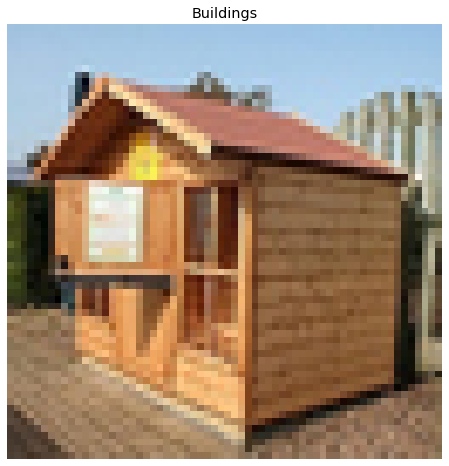

In [4]:
index = 9

plt.imshow(datas['features'][index])
plt.title(datas['labels'][index])
plt.axis(False)
plt.show()

### Export images (in the `datas` dict) into multiple pickle files
Export images into .pickle files. To limit the file size, each .pickle file will contain 750 data points (the image itself along with its label).

In [5]:
data_points_per_file = 750

for i in range(int(len(datas['features']) / data_points_per_file) + 1):
    start = i * data_points_per_file
    end = min((i + 1) * data_points_per_file, len(datas['features']))
    temp_data = {
        'features': datas['features'][start: end],
        'labels': datas['labels'][start: end],
    }
    # opens creates a .pickle file and saves the contents of temp_data to the file
    with open('./data/images_%d.pickle' % (i + 1), 'wb') as f:
        pickle.dump(temp_data, f)
    print(start, '-', end, '-> exported')
print(i)

del i
del start
del end
del temp_data

0 - 750 -> exported
750 - 1500 -> exported
1500 - 2250 -> exported
2250 - 3000 -> exported
3000 - 3750 -> exported
3750 - 4500 -> exported
4500 - 5250 -> exported
5250 - 6000 -> exported
6000 - 6750 -> exported
6750 - 7500 -> exported
7500 - 8250 -> exported
8250 - 9000 -> exported
9000 - 9750 -> exported
9750 - 10500 -> exported
10500 - 11250 -> exported
11250 - 12000 -> exported
12000 - 12750 -> exported
12750 - 13500 -> exported
13500 - 14250 -> exported
14250 - 15000 -> exported
15000 - 15750 -> exported
15750 - 16500 -> exported
16500 - 17034 -> exported
22


## Import data

### Import Data from pickle file
Since the overall data are splitted into seperate pickle files, there is a need to open each file and combine the data all together.

In [3]:
X = []
y = []

# loop each file in ./data directory
for root, _, files in os.walk('./data'):
    for file in files:
        # only open if pickle file
        if('.pickle' in file):
            with open('./data/%s' % file, 'rb') as f:
                images = pickle.load(f)
                if(len(X) > 0):
                    X = np.concatenate([X, images['features']])
                    y = np.concatenate([y, images['labels']])
                else:
                    # if first file, concatenate wouldn't work so it is required 
                    # to assign the contents of the first file as np.array
                    X = np.array(images['features'])
                    y = np.array(images['labels'])
                print(file, '-> imported')

total_images = len(X)
print('Total Images:', total_images)

del root
del files
del images

images_1.pickle -> imported
images_2.pickle -> imported
images_3.pickle -> imported
images_4.pickle -> imported
images_5.pickle -> imported
images_6.pickle -> imported
images_7.pickle -> imported
images_8.pickle -> imported
images_9.pickle -> imported
images_10.pickle -> imported
images_11.pickle -> imported
images_12.pickle -> imported
images_13.pickle -> imported
images_14.pickle -> imported
images_15.pickle -> imported
images_16.pickle -> imported
images_17.pickle -> imported
images_18.pickle -> imported
images_19.pickle -> imported
images_20.pickle -> imported
images_21.pickle -> imported
images_22.pickle -> imported
images_23.pickle -> imported
Total Images: 17034


## Exploratory Data Analysis

### Checking how many of each classes is in the dataset

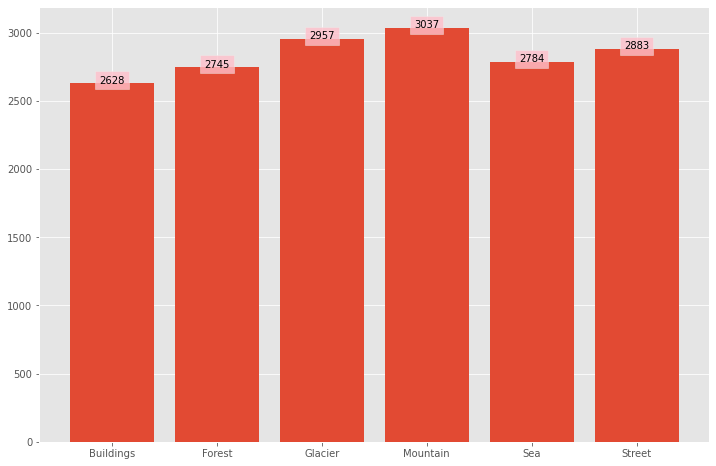

In [4]:
counts = Counter(y)
_ = plt.bar(counts.keys(), counts.values())

for key, val in counts.items():
    plt.text(key, val, val, ha='center', bbox=dict(facecolor='pink', alpha=0.8))

Based on the graph, it can be seen that there are `2628 buildings`, `2745 forests`, `2957 glaciers`, `3037 mountains`, `2784 sea` and `2883 streets`.

### Visualizing the Images
Show 4 sample images for each class

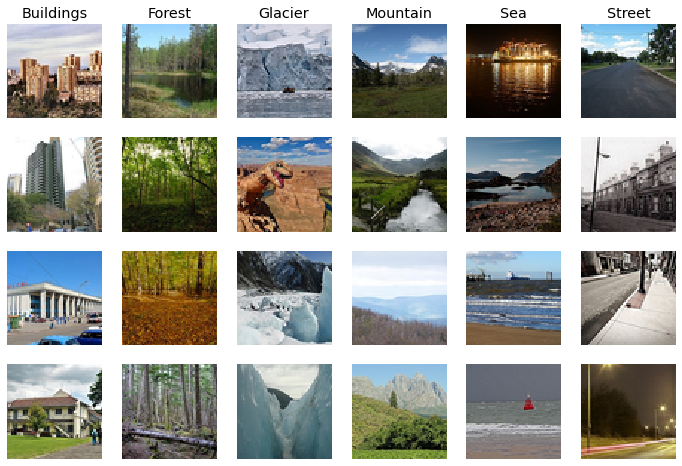

In [5]:
classes = list(counts.keys())

num_classes = len(classes)
samples_per_class = 4

for j, cls in enumerate(classes):
    idxs = np.flatnonzero(y == cls)
    idxs = np.random.choice(idxs, samples_per_class, replace=False) 
    for i, idx in enumerate(idxs):
        # show items in column (per class)
        plt_idx = i * num_classes + j + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

del j
del cls
del idxs
del plt_idx

Based on the group of images above, it is safe to assume that the dataset is labelled correctly.

## Data Processsing 

### Split the data into train and test datasets
The test size will be 20% of the dataset and will be stratified based on the labels. Uses the `train_test_split` function from the `sklearn.model_selection` library.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Since we already have X_train, X_test, y_train, and y_test, 
# We won't be needing X, and y from this point.
del X
del y

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (13627, 64, 64, 3)
Training labels shape:  (13627,)
Test data shape:  (3407, 64, 64, 3)
Test labels shape:  (3407,)


#### Visualize Distribution for Train Dataset

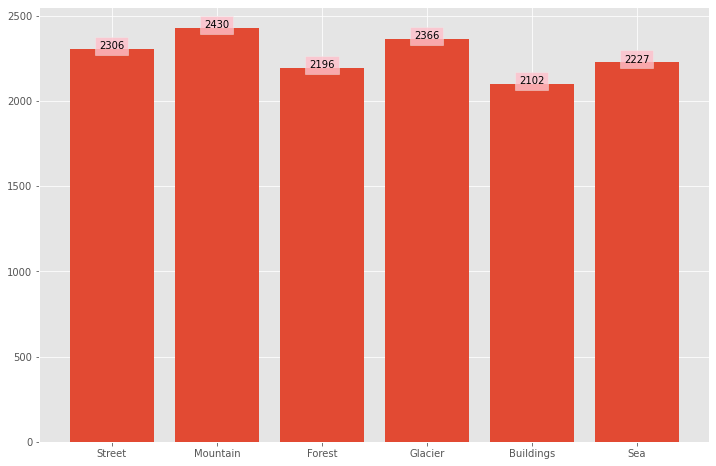

In [7]:
counts = Counter(y_train)
_ = plt.bar(counts.keys(), counts.values())

for key, val in counts.items():
    plt.text(key, val, val, ha='center', bbox=dict(facecolor='pink', alpha=0.8))

#### Visualize Distribution for Test Dataset

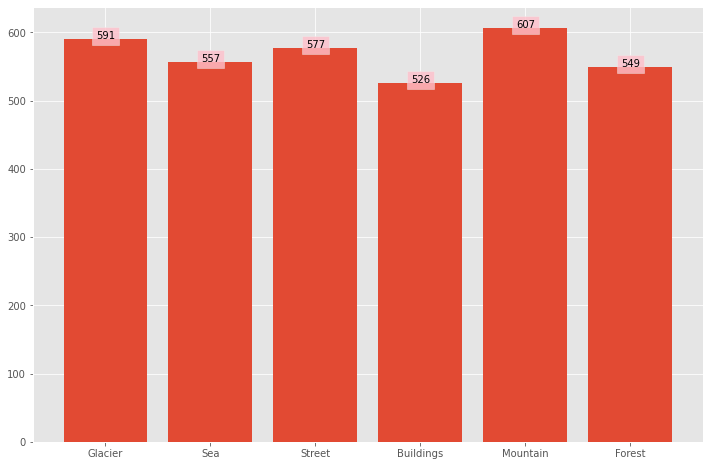

In [8]:
counts = Counter(y_test)
_ = plt.bar(counts.keys(), counts.values())

for key, val in counts.items():
    plt.text(key, val, val, ha='center', bbox=dict(facecolor='pink', alpha=0.8))
    
del counts

After visualizing the distribution of training and test data, **the distribution of each classes is good** and is almost equal with one another.

### Convert 3D array which represents the image into a 1D array
The original shape of each image from the .pickle files is (64, 64, 3) which represents (pixel height, pixel width, rgb values). To turn these into 1D, we have to reshape each image into 64 x 64 x 3 = 12288.

In [9]:
single_dimension = 64 * 64 * 3
X_train = X_train.reshape([len(X_train), single_dimension])
X_test = X_test.reshape([len(X_test), single_dimension])
print(X_train.shape)
print(X_test.shape)

(13627, 12288)
(3407, 12288)


### Convert the labels from `string` into `integer` index
ex. from `[Buildings, Buildings, Forest]` to `[0, 0, 1]`

In [10]:
y_train = np.array([classes.index(y) for y in y_train])
y_test = np.array([classes.index(y) for y in y_test])
print(y_train)
print(y_test)

[5 3 1 ... 5 1 5]
[2 2 4 ... 2 5 0]


## Metric
The image classification metric will mainly be based on the accuracy of the model in percentage. That is:  $$Accuracy = (\frac{Correct Predictions}{Total Predictions}) \times 100$$

In [11]:
def calculate_accuracy(predictions, actual):
    assert len(predictions) == len(actual)

    # Correct Predictions / Total Predictions
    return (np.sum([predictions == actual]) / len(predictions)) * 100

## Models
3 models have been developed for this dataset:
1. [K Nearest Neighbors](#K-Nearest-Neighbors) 
2. [Neural Network](#Neural-Network)
3. [Convolutional Neural Network](#CNN)

For each model, there are 3 parts:
1. **Hyperparameter Tuning**  
In this section, the best possible hyperparameters will be searched either manually or through existing libraries. 
2. **Training the Best Model**  
In this section, the best model with the best accuracy from the **Hyperparameter Tuning** will be trained.
3. **Evaluating the Performance**  
In this section, the trained best model's performance will be evaluated based on accuracy on predicting each class and overall accuracy.

### K Nearest Neighbors
K Nearest Neighbors algorithm is chosen with the intent of applying what we've learned from the STINTSY class and testing whether or not the algorithm would perform well for image datasets.  

This experiment makes use of the default distance metric `euclidean distance`. 

#### Apply K Fold and determine the best `n_neighbors` value.

Hyperparameter tuning is done through random hyperparameter search to know which value of `n_neighbors` works well for these set of images.   
*Note: you can skip this part if you want to directly train using the best model*

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

k_folds = 5

hyperparameters = {
    'n_neighbors': [25, 50, 75, 100, 250],
}

knn = KNeighborsClassifier()

In [13]:
rs_knn = GridSearchCV(knn, hyperparameters, cv=k_folds, verbose=3)

rs_knn.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ....................n_neighbors=25;, score=0.442 total time=   3.8s
[CV 2/5] END ....................n_neighbors=25;, score=0.440 total time=   3.7s
[CV 3/5] END ....................n_neighbors=25;, score=0.457 total time=   4.0s
[CV 4/5] END ....................n_neighbors=25;, score=0.432 total time=   3.8s
[CV 5/5] END ....................n_neighbors=25;, score=0.443 total time=   3.9s
[CV 1/5] END ....................n_neighbors=50;, score=0.453 total time=   4.0s
[CV 2/5] END ....................n_neighbors=50;, score=0.454 total time=   3.7s
[CV 3/5] END ....................n_neighbors=50;, score=0.460 total time=   3.8s
[CV 4/5] END ....................n_neighbors=50;, score=0.440 total time=   3.7s
[CV 5/5] END ....................n_neighbors=50;, score=0.450 total time=   3.7s
[CV 1/5] END ....................n_neighbors=75;, score=0.449 total time=   3.8s
[CV 2/5] END ....................n_neighbors=75;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [25, 50, 75, 100, 250]}, verbose=3)

In [15]:
rs_knn.cv_results_

{'mean_fit_time': array([0.03199949, 0.03099961, 0.02940292, 0.03440208, 0.03280354]),
 'std_fit_time': array([0.00374055, 0.00253003, 0.00195801, 0.00344005, 0.00617569]),
 'mean_score_time': array([3.92294941, 3.85079675, 3.83639293, 3.91141095, 3.91319408]),
 'std_score_time': array([0.07976828, 0.096902  , 0.06638534, 0.11613074, 0.06648631]),
 'param_n_neighbors': masked_array(data=[25, 50, 75, 100, 250],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 25},
  {'n_neighbors': 50},
  {'n_neighbors': 75},
  {'n_neighbors': 100},
  {'n_neighbors': 250}],
 'split0_test_score': array([0.44167278, 0.45341159, 0.44900954, 0.44790902, 0.43947175]),
 'split1_test_score': array([0.44020543, 0.45377843, 0.44937638, 0.4486427 , 0.44350697]),
 'split2_test_score': array([0.45651376, 0.45981651, 0.45798165, 0.45394495, 0.44440367]),
 'split3_test_score': array([0.43192661, 0.43963303, 0.43853211, 0.4333945 , 

#### Hyperparameter Search Results:  
<table>
    <tr><th>N Neighbors</th><th>Average Test Score on Validation Set</th></tr>
    <tr><td>25</td><td>44.27%</td></tr>
    <tr><td>50</td><td>45.14%</td></tr>
    <tr><td>75</td><td>44.95%</td></tr>
    <tr><td>100</td><td>44.71%</td></tr>
    <tr><td>250</td><td>43.88%</td></tr>
</table>

In [15]:
rs_knn.best_params_

{'n_neighbors': 50}

As can be seen in the results, the parameter `{'n_neighbors': 50}` had the best result

#### Training with the best `n_neighbors` value

In [16]:
best_neighbors = 50
model = KNeighborsClassifier(n_neighbors=50)

model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=50)

#### Evaluating Performance

In [17]:
knn_y_pred = model.predict(X_test)

In [18]:
building_indexes = np.where(y_test == 0)
forest_indexes = np.where(y_test == 1)
glacier_indexes = np.where(y_test == 2)
mountain_indexes = np.where(y_test == 3)
sea_indexes = np.where(y_test == 4)
street_indexes = np.where(y_test == 5)

print('KNN Model Accuracy for Buildings: %.2f%%' % calculate_accuracy(knn_y_pred[building_indexes], y_test[building_indexes]))
print('KNN Model Accuracy for Forest: %.2f%%' % calculate_accuracy(knn_y_pred[forest_indexes], y_test[forest_indexes]))
print('KNN Model Accuracy for Glaciers: %.2f%%' % calculate_accuracy(knn_y_pred[glacier_indexes], y_test[glacier_indexes]))
print('KNN Model Accuracy for Mountain: %.2f%%' % calculate_accuracy(knn_y_pred[mountain_indexes], y_test[mountain_indexes]))
print('KNN Model Accuracy for Sea: %.2f%%' % calculate_accuracy(knn_y_pred[sea_indexes], y_test[sea_indexes]))
print('KNN Model Accuracy for Streets: %.2f%%' % calculate_accuracy(knn_y_pred[street_indexes], y_test[street_indexes]))
print('Overall KNN Model Accuracy: %.2f%%' % calculate_accuracy(knn_y_pred, y_test))

KNN Model Accuracy for Buildings: 1.71%
KNN Model Accuracy for Forest: 80.69%
KNN Model Accuracy for Glaciers: 50.25%
KNN Model Accuracy for Mountain: 78.58%
KNN Model Accuracy for Sea: 41.11%
KNN Model Accuracy for Streets: 19.24%
Overall KNN Model Accuracy: 45.96%


Based on the results, the overall accuracy of the KNN model is **45.96%**. It performed the best on predicting Forests and did the worst on predicting Buildings.

### Fully-Connected Neural Network
Neural Network was chosen as the 2nd model due to its popularity in general. It has proven itself to be a reliable model no matter what type of data is being used.

The Neural Network will be developed using the **PyTorch library**. A `neural_network.py` file has been created and contains the neural network used for this dataset.
#### Data Preprocessing for Neural Network

##### Convert train and test data to PyTorch DataLoader 
For convenience, PyTorch's DataLoader will be used to seperate the data into batches.

In [16]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

batch_size = 128

# setup dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# get first batch
next(iter(train_loader))[0].shape

torch.Size([128, 12288])

#### Developing the Neural Network Model
To develop the **Neural Network** model with the best possible results, the hyperparameters are searched manually. The hyperparameters are manually changed then the model will be trained. The results of the model will be tracked to determine the best hyperparameters at the end.

The `neural_network.py` file is imported. Then the hyperparameters are initialized.

**Cross Entropy Loss** will be used as the loss function and **Adam** will be used as the optimization algorithm

In [26]:
from neural_network import NeuralNetwork

# setting the hyperparameters
input_size = single_dimension # 64 * 64 * 3|
list_hidden = [4096, 4096]
num_classes = len(classes)

model = NeuralNetwork(input_size, list_hidden, num_classes).to(device)
model

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=12288, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=4096, out_features=4096, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=4096, out_features=6, bias=True)
    (5): Softmax(dim=1)
  )
)

The Neural Network is a fully connected network composed of multiple layers which is dependent on the `list_hidden` parameter.

Each layer is composed of a **Linear layer** followed by a **ReLU activation function** (to avoid negative values since the R, G, and B values are only from 0-255)

Finally, a **Softmax activation function** is used at the end for calculating the probabilities in each class. 

The image below shows the diagram of the Neural Network Diagram of the model with the best results
<img src='./diagrams/best_neural_network.png' width='50%' alt='Best Neural Network Model' />

In [27]:
criterion = nn.CrossEntropyLoss()

In [28]:
learning_rate = 0.0001
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

#### Manual Hyperparameter Search Results:
<table>
<tr><th>Batch Size</th><th>Hidden Layers</th><th>Learning Rate</th><th>Stopped at Epoch</th><th>Last Average Loss</th><th>Train Accuracy</th><th>Test Accuracy</th></tr>
<tr><td>128</td><td>128, 64</td><td>0.0001</td><td>200</td><td>1.015868</td><td>73.60%</td><td>51.13%</td><tr>
<tr><td>128</td><td>128, 64, 32</td><td>0.001</td><td>200</td><td>1.064374</td><td>75.03%</td><td>55.09%</td><tr>
<tr><td>128</td><td>128, 64, 32, 16, 8</td><td>0.0001</td><td>200</td><td>0.702044</td><td>79.86%</td><td>56.44%</td><tr>
<tr><td>128</td><td>4096, 4096</td><td>0.0001</td><td>200</td><td>89.013612</td><td>95.82%</td><td>60.29%</td><tr>
<tr><td>256</td><td>256</td><td>0.00005</td><td>200</td><td>7.816679</td><td>79.94%</td><td>50.10%</td><tr>
<tr><td>256</td><td>256, 128</td><td>0.00005</td><td>200</td><td>0.960638</td><td>89.82%</td><td>49.52%</td><tr>
<tr><td>256</td><td>256, 128, 64</td><td>0.00005</td><td>200</td><td>0.378204</td><td>85.50%</td><td>49.93%</td><tr>
<tr><td>256</td><td>1024</td><td>0.00002</td><td>200</td><td>18.548714</td><td>84.71%</td><td>50.34%</td><tr>
<tr><td>256</td><td>1024, 512</td><td>0.0001</td><td>200</td><td>7.224179</td><td>88.82%</td><td>54.80%</td><tr>
<tr><td>256</td><td>1024, 512, 256</td><td>0.00005</td><td>200</td><td>2.715007</td><td>94.87%</td><td>54.21%</td><tr>
<tr><td>256</td><td>1024, 512, 256, 128</td><td>0.00005</td><td>200</td><td>1.972283</td><td>95.16%</td><td>54.24%</td><tr>
<tr><td>256</td><td>4096, 4096</td><td>0.00005</td><td>200</td><td>32.118587</td><td>95.71%</td><td>58.73%</td><tr>
<table>
    
The hyperparameter search took place for approximately 4 hours. 

Through discovering different combinations of `batch_size`, `hidden_layer`, and `learning_rate`, the ones with the best result are:   
`{batch_size: 128, hidden_list: [4096, 4096], learning_rate: 0.0001}` which achieved a `60.29%` accuracy.

#### Training the Neural Network Model
When training the model, the max epoch is set to 200. 

To check whether the gradients have converged or not, the loss is checked to see if there are changes from the previous iteration.

In [29]:
e = 0
max_epochs = 200
is_converged = False
previous_loss = 0
losses = []

while e < max_epochs and is_converged is not True:
    current_epoch_loss = 0

    for i, (images, labels) in enumerate(train_loader):
        X_batch = images.to(device)
        y_batch = labels.to(device)

        # Empty the gradients of the network.
        optimizer.zero_grad()

        # Forward propagation
        outputs, probabilities = model.forward(X_batch)

        # Compute the loss
        loss = criterion(outputs, y_batch)

        # Backward propagation
        loss.backward()

        # Update parameters
        optimizer.step()

        current_epoch_loss += loss.item()

    average_loss = current_epoch_loss / len(X_batch)
    losses.append(average_loss)

    # Display the average loss per epoch
    print('Epoch:', e + 1, '\tLoss: {:.6f}'.format(average_loss))
    
    if abs(previous_loss - loss) < 0.00001 * previous_loss:
        is_converged = True
    else:
        previous_loss = loss
        e += 1

Epoch: 1 	Loss: 17495.505992
Epoch: 2 	Loss: 6926.739771
Epoch: 3 	Loss: 6076.622650
Epoch: 4 	Loss: 5501.161975
Epoch: 5 	Loss: 4588.637077
Epoch: 6 	Loss: 4113.405598
Epoch: 7 	Loss: 3205.080489
Epoch: 8 	Loss: 2848.096076
Epoch: 9 	Loss: 2809.761972
Epoch: 10 	Loss: 2456.398820
Epoch: 11 	Loss: 2617.054723
Epoch: 12 	Loss: 2344.313891
Epoch: 13 	Loss: 2028.587304
Epoch: 14 	Loss: 2015.424072
Epoch: 15 	Loss: 1881.326633
Epoch: 16 	Loss: 1712.099506
Epoch: 17 	Loss: 1177.432782
Epoch: 18 	Loss: 983.972671
Epoch: 19 	Loss: 925.419630
Epoch: 20 	Loss: 838.614515
Epoch: 21 	Loss: 945.588757
Epoch: 22 	Loss: 1175.564047
Epoch: 23 	Loss: 1072.412409
Epoch: 24 	Loss: 916.306010
Epoch: 25 	Loss: 1020.626027
Epoch: 26 	Loss: 1038.957581
Epoch: 27 	Loss: 967.031983
Epoch: 28 	Loss: 908.836280
Epoch: 29 	Loss: 756.351465
Epoch: 30 	Loss: 539.608537
Epoch: 31 	Loss: 502.337728
Epoch: 32 	Loss: 483.507648
Epoch: 33 	Loss: 632.068935
Epoch: 34 	Loss: 633.001051
Epoch: 35 	Loss: 659.090120
Epoch: 

#### Visualizing the Training Loss

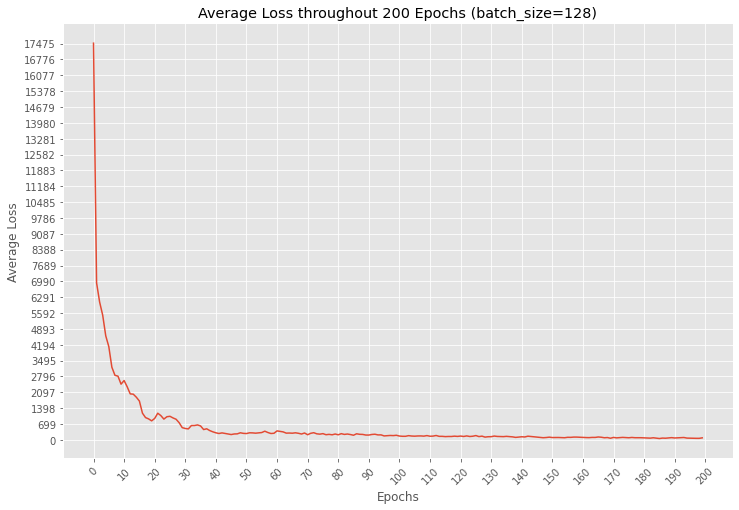

In [31]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Average Loss throughout %d Epochs (batch_size=%d)' % (max_epochs, batch_size))
plt.yticks(np.arange(0, max(losses) + 1, int(max(losses) / 25)))
plt.xticks(np.arange(0, max_epochs + 1, 10), rotation=45)
plt.show()

#### Evaluating the Performance

##### Train Dataset Results

In [32]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in train_loader:
        X_batch = images.to(device)
        y_batch = labels.to(device)

        outputs, probabilities = model.forward(X_batch)

        predictions = model.predict(probabilities)

        n_correct += (predictions == y_batch).sum().item()
        n_samples += len(X_batch)
    print('Neural Network Model Accuracy (Train): %.2f%%' % ((n_correct / n_samples) * 100))

Neural Network Model Accuracy (Train): 95.82%


##### Test Dataset Results

In [33]:
buildings = { 'correct': 0, 'total': 0 }
forests = { 'correct': 0, 'total': 0 }
glaciers = { 'correct': 0, 'total': 0 }
mountains = { 'correct': 0, 'total': 0 }
sea = { 'correct': 0, 'total': 0 }
streets = { 'correct': 0, 'total': 0 }

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        X_batch = images.to(device)
        y_batch = labels.to(device)
        
        building_indexes = np.where(y_batch.cpu() == 0)
        forest_indexes = np.where(y_batch.cpu() == 1)
        glacier_indexes = np.where(y_batch.cpu() == 2)
        mountain_indexes = np.where(y_batch.cpu() == 3)
        sea_indexes = np.where(y_batch.cpu() == 4)
        street_indexes = np.where(y_batch.cpu() == 5)

        outputs, probabilities = model.forward(X_batch)

        predictions = model.predict(probabilities)

        buildings['correct'] += (predictions[building_indexes] == y_batch[building_indexes]).sum()
        buildings['total'] += len(predictions[building_indexes])
        forests['correct'] += (predictions[forest_indexes] == y_batch[forest_indexes]).sum()
        forests['total'] += len(predictions[forest_indexes])
        glaciers['correct'] += (predictions[glacier_indexes] == y_batch[glacier_indexes]).sum()
        glaciers['total'] += len(predictions[glacier_indexes])
        mountains['correct'] += (predictions[mountain_indexes] == y_batch[mountain_indexes]).sum()
        mountains['total'] += len(predictions[mountain_indexes])
        sea['correct'] += (predictions[sea_indexes] == y_batch[sea_indexes]).sum()
        sea['total'] += len(predictions[sea_indexes])
        streets['correct'] += (predictions[street_indexes] == y_batch[street_indexes]).sum()
        streets['total'] += len(predictions[street_indexes])

        n_correct += (predictions == y_batch).sum().item()
        n_samples += len(X_batch)
    print('Neural Network Model Accuracy (Test): %.2f%%' % ((n_correct / n_samples) * 100))

Neural Network Model Accuracy (Test): 60.29%


##### Results for each Class

In [34]:
print('KNN Model Accuracy for Buildings: %.2f%%' % ((buildings['correct'] / buildings['total']) * 100))
print('KNN Model Accuracy for Forest: %.2f%%' % ((forests['correct'] / forests['total']) * 100))
print('KNN Model Accuracy for Glaciers: %.2f%%' % ((glaciers['correct'] / glaciers['total']) * 100))
print('KNN Model Accuracy for Mountain: %.2f%%' % ((mountains['correct'] / mountains['total']) * 100))
print('KNN Model Accuracy for Sea: %.2f%%' % ((sea['correct'] / sea['total']) * 100))
print('KNN Model Accuracy for Streets: %.2f%%' % ((streets['correct'] / streets['total']) * 100))

KNN Model Accuracy for Buildings: 40.68%
KNN Model Accuracy for Forest: 76.32%
KNN Model Accuracy for Glaciers: 61.42%
KNN Model Accuracy for Mountain: 63.92%
KNN Model Accuracy for Sea: 55.30%
KNN Model Accuracy for Streets: 62.74%


### CNN
Convolutional Neural Network was chosen as the 3rd model because of its popularity of usage in image datasets due to its performance.

The Convolutional Neural Network will be developed using the **PyTorch library**. A `convolutional_neural_network.py` file has been created and contains the CNN used for this dataset.

#### Data Preprocessing for CNN
Originally, the shape of the `X_train` and `X_test` is (number of data points, 12288). To be able to use it for a CNN Model, it has to be converted into (3, 64, 64)

##### Convert Train and Test Data to Data Loaders

In [35]:
# Convert images to X_train and X_test to (3, 64, 64) shape to pass it on CNN
# Then passed train and test datasets to form a TensorDataset 
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train.reshape(-1, 64, 64, 3).transpose((0, 3, 1, 2)), dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test.reshape(-1, 64, 64, 3).transpose((0, 3, 1, 2)), dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

batch_size = 32

# Setup dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

next(iter(train_loader))[0].shape

torch.Size([32, 3, 64, 64])

#### Developing the CNN
The Hyperparameter tuning method applied is same with the previous section [Developing the Neural Network Model](#Developing-the-Neural-Network-Model)

**Cross Entropy Loss** will be used as the loss function and **Adam** will be used as the optimization algorithm

In [36]:
from convolutional_neural_network import ConvolutionalNeuralNetwork

# initialization of hyperparameters
input_size = single_dimension # 64 * 64 * 3
in_channels = 3
num_classes = len(classes)

model = ConvolutionalNeuralNetwork(input_size, in_channels, num_classes).to(device)
model

ConvolutionalNeuralNetwork(
  (feature_extraction): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2

Since the team had minimal knowledge regarding CNNs, the team applied **VGG-16's ConvNet D configurations**. 

The network consists of 5 convolutional layer which extracts the features of certain parts of the image. Each convolutional layer is followed by a max pooling layer. 

After that, it is **flattened** then **passed into a fully connected hidden layer** composed of 2 hidden layer **that has 4096 nodes each**. Each hidden layer is followed by a **dropout regularization layer with a dropout ratio of 0.5**.

For each layer except the dropout regularization layer and max pooling layer, a **ReLU activation function was used to prevent negative values** since an R, G, and B can only be from 0-255. 

Finally a **softmax activation function has been used at the end** to get the probability for each classes.

The image below shows the diagram of the VGG-16 configuration D for this dataset
<img src='./diagrams/vgg_16.png' width='75%' alt='Best Convolutional Neural Network Model' />

In [37]:
criterion = nn.CrossEntropyLoss()

In [38]:
learning_rate = 0.00005
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

#### Manual Hyperparameter Search Results:  
<table>
    <tr><th>Batch Size</th><th>Learning Rate</th><th>Stopped at Epoch</th><th>Last Average Loss</th><th>Train Accuracy</th><th>Test Accuracy</th></tr>
    <tr><td>32</td><td>0.00005</td><td>25</td><td>0.983392</td><td>96.07%</td><td>81.95%</td></tr>
    <tr><td>32</td><td>0.00005</td><td>50</td><td>0.475706</td><td>99.04%</td><td>84.91%</td></tr>
    <tr><td>32</td><td>0.0001</td><td>25</td><td>1.080159</td><td>97.52%</td><td>83.80%</td></tr>
    <tr><td>32</td><td>0.0001</td><td>50</td><td>0.221535</td><td>99.49%</td><td>84.80%</td></tr>
    <tr><td>64</td><td>0.0001</td><td>25</td><td>0.310252</td><td>94.32%</td><td>81.36%</td></tr>
    <tr><td>128</td><td>0.0001</td><td>25</td><td>0.197657</td><td>94.06%</td><td>83.12%</td></tr>
</table>

The hyperparameter search took place for approximately 3 hours. 

Through discovering different combinations of `batch_size`, `learning_rate`, and `max_epoch`, the ones with the best result are:   
`{batch_size: 32, learning_rate: 0.00005, epoch: 50}` which achieved a `84.91%` accuracy.

#### Training the CNN
For training the CNN, the max epochs is set to 50. 

The method applied for detecting whether the gradient has converged is same with [Training the Neural Network Model](#Training-the-Neural-Network-Model)

In [39]:
e = 0
max_epochs = 50
is_converged = False
previous_loss = 0
losses = []

while e < max_epochs and is_converged is not True:
    current_epoch_loss = 0

    for i, (images, labels) in enumerate(train_loader):
        X_batch = images.to(device)
        y_batch = labels.to(device)

        # Empty the gradients of the network.
        optimizer.zero_grad()

        # Forward propagation
        outputs, probabilities = model.forward(X_batch)

        # Compute the loss
        loss = criterion(outputs, y_batch)

        # Backward propagation
        loss.backward()

        # Update parameters
        optimizer.step()

        current_epoch_loss += loss.item()

    average_loss = current_epoch_loss / len(X_batch)
    losses.append(average_loss)

    # Display the average loss per epoch
    print('Epoch:', e + 1, '\tLoss: {:.6f}'.format(average_loss))
    
    if abs(previous_loss - loss) < 0.00001 * previous_loss:
        is_converged = True
    else:
        previous_loss = loss
        e += 1

Epoch: 1 	Loss: 20.475981
Epoch: 2 	Loss: 14.290550
Epoch: 3 	Loss: 12.219981
Epoch: 4 	Loss: 10.421904
Epoch: 5 	Loss: 9.016964
Epoch: 6 	Loss: 7.951268
Epoch: 7 	Loss: 7.391479
Epoch: 8 	Loss: 6.483940
Epoch: 9 	Loss: 5.661308
Epoch: 10 	Loss: 5.083191
Epoch: 11 	Loss: 4.506722
Epoch: 12 	Loss: 4.066374
Epoch: 13 	Loss: 3.565875
Epoch: 14 	Loss: 3.507143
Epoch: 15 	Loss: 2.794612
Epoch: 16 	Loss: 2.734087
Epoch: 17 	Loss: 2.477142
Epoch: 18 	Loss: 2.129328
Epoch: 19 	Loss: 1.837026
Epoch: 20 	Loss: 1.620492
Epoch: 21 	Loss: 1.519636
Epoch: 22 	Loss: 1.431499
Epoch: 23 	Loss: 1.243738
Epoch: 24 	Loss: 1.135214
Epoch: 25 	Loss: 1.127152
Epoch: 26 	Loss: 0.760133
Epoch: 27 	Loss: 0.967117
Epoch: 28 	Loss: 0.845860
Epoch: 29 	Loss: 0.732187
Epoch: 30 	Loss: 0.770507
Epoch: 31 	Loss: 0.677328
Epoch: 32 	Loss: 0.844322
Epoch: 33 	Loss: 0.633842
Epoch: 34 	Loss: 0.565618
Epoch: 35 	Loss: 0.702009
Epoch: 36 	Loss: 0.538675
Epoch: 37 	Loss: 0.485720
Epoch: 38 	Loss: 0.525411
Epoch: 39 	Loss: 

#### Visualizing the Training Loss

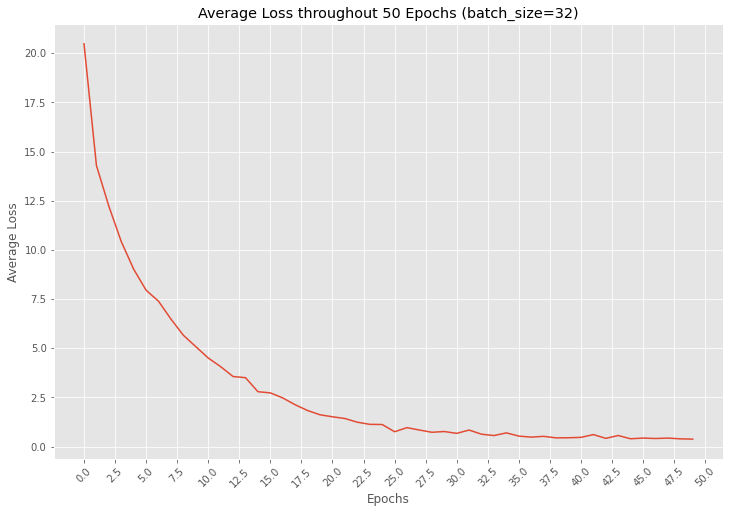

In [40]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Average Loss throughout %d Epochs (batch_size=%d)' % (max_epochs, batch_size))
plt.yticks(np.arange(0, max(losses) + 1, 2.5))
plt.xticks(np.arange(0, max_epochs + 1, 2.5), rotation=45)
plt.show()

#### Evaluating the Performance

##### Train Data Results

In [41]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in train_loader:
        X_batch = images.to(device)
        y_batch = labels.to(device)

        _, probabilities = model.forward(X_batch)

        predictions = model.predict(probabilities)

        n_correct += (predictions == y_batch).sum().item()
        n_samples += len(X_batch)
    print('Neural Network Model Accuracy (Train): %.2f%%' % ((n_correct / n_samples) * 100))

Neural Network Model Accuracy (Train): 99.61%


##### Test Data Results

In [42]:
buildings = {
    'correct': 0,
    'total': 0
}
forests = {
    'correct': 0,
    'total': 0
}
glaciers = {
    'correct': 0,
    'total': 0
}
mountains = {
    'correct': 0,
    'total': 0
}
sea = {
    'correct': 0,
    'total': 0
}
streets = {
    'correct': 0,
    'total': 0
}

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        X_batch = images.to(device)
        y_batch = labels.to(device)

        building_indexes = np.where(y_batch.cpu() == 0)
        forest_indexes = np.where(y_batch.cpu() == 1)
        glacier_indexes = np.where(y_batch.cpu() == 2)
        mountain_indexes = np.where(y_batch.cpu() == 3)
        sea_indexes = np.where(y_batch.cpu() == 4)
        street_indexes = np.where(y_batch.cpu() == 5)

        _, probabilities = model.forward(X_batch)

        predictions = model.predict(probabilities)

        buildings['correct'] += (predictions[building_indexes] == y_batch[building_indexes]).sum()
        buildings['total'] += len(predictions[building_indexes])
        forests['correct'] += (predictions[forest_indexes] == y_batch[forest_indexes]).sum()
        forests['total'] += len(predictions[forest_indexes])
        glaciers['correct'] += (predictions[glacier_indexes] == y_batch[glacier_indexes]).sum()
        glaciers['total'] += len(predictions[glacier_indexes])
        mountains['correct'] += (predictions[mountain_indexes] == y_batch[mountain_indexes]).sum()
        mountains['total'] += len(predictions[mountain_indexes])
        sea['correct'] += (predictions[sea_indexes] == y_batch[sea_indexes]).sum()
        sea['total'] += len(predictions[sea_indexes])
        streets['correct'] += (predictions[street_indexes] == y_batch[street_indexes]).sum()
        streets['total'] += len(predictions[street_indexes])

        n_correct += (predictions == y_batch).sum().item()
        n_samples += len(X_batch)
    print('Neural Network Model Accuracy (Test): %.2f%%' % ((n_correct / n_samples) * 100))

Neural Network Model Accuracy (Test): 85.32%


##### Results for each Class

In [43]:
print('KNN Model Accuracy for Buildings: %.2f%%' % ((buildings['correct'] / buildings['total']) * 100))
print('KNN Model Accuracy for Forest: %.2f%%' % ((forests['correct'] / forests['total']) * 100))
print('KNN Model Accuracy for Glaciers: %.2f%%' % ((glaciers['correct'] / glaciers['total']) * 100))
print('KNN Model Accuracy for Mountain: %.2f%%' % ((mountains['correct'] / mountains['total']) * 100))
print('KNN Model Accuracy for Sea: %.2f%%' % ((sea['correct'] / sea['total']) * 100))
print('KNN Model Accuracy for Streets: %.2f%%' % ((streets['correct'] / streets['total']) * 100))

KNN Model Accuracy for Buildings: 82.32%
KNN Model Accuracy for Forest: 95.26%
KNN Model Accuracy for Glaciers: 83.59%
KNN Model Accuracy for Mountain: 80.07%
KNN Model Accuracy for Sea: 85.28%
KNN Model Accuracy for Streets: 85.96%


## Results

### Table of Results
<table>
    <tr><th>Model</th><th>Best Hyperparameters</th><th>Buildings Acc</th><th>Forest Acc</th><th>Glaciers Acc</th><th>Mountains Acc</th><th>Sea Acc</th><th>Streets Acc</th><th>Overall Acc</th></tr>
    <tr><td>K Nearest Neighbor</td><td><code>{n_neighbors: 50}</code></td><td>1.71%</td><td>80.69%</td><td>50.25%</td><td>78.58%</td><td>41.11%</td><td>19.24%</td><td><strong>45.96%</strong></td></tr>
    <tr><td>Neural Network</td><td><code>{batch_size: 128, hidden_list: [4096, 4096], learning_rate: 0.0001, epochs: 200}</code></td><td>40.68%</td><td>76.32%</td><td>61.42%</td><td>63.92%</td><td>55.30%</td><td>62.74%</td><td><strong>60.29%</strong></td></tr>
    <tr><td>Convolutional Neural Network</td><td><code>{batch_size:32, learning_rate: 0.00005, epochs: 50}</code></td><td>82.32%</td><td>95.26%</td><td>83.59%</td><td>80.07%</td><td>85.28%</td><td>85.96%</td><td><strong>84.91%</strong></td></tr>
</table>

### Graph of Results
<img src="./diagrams/best_model_results_graph.png" alt='Best Models Graph' />

## Insights  

The following are the list of insights gained from the results:
1. The model with the best overall performance is the **Convolutional Neural Network** model.
2. All the models are having a *hard time* on classifying a **Building** image since all the models are not performing well in predicting it.
3. On the other hand, all models are *performing well* on classifying **Forest** images.
4. From training the **CNNs** vs **Neural Networks**, the team has observed that **CNNs** takes a *fewer epochs* (50) for the model to get the best results compared to **Neural Networks** (200). 
5. The contributions of this research was mainly a comparitive study of the 3 models **K Nearest Neighbors**, **Neural Network**, and **Convolutional Neural Network**.

## Comparing with Existing Kaggle Solutions
The existing solutions in Kaggle performs better compared to the CNN model produced by this notebook.  
- [arbazkhan971](https://www.kaggle.com/code/arbazkhan971/image-classification-using-cnn-94-accuracy) applied ResNet18 and acquired 94% accuracy.  
- [uzairrj](https://www.kaggle.com/code/uzairrj/beg-tut-intel-image-classification-93-76-accur) applied dense instead of linear layers and made his own convolutional layers which achieved a 93.76% accuracy. 

But this shouldn't matter much in this study since we've accomplished the main task of comparing the models from one another and the best model from the kaggle solutions.

## Recommendations
The following are the list of recommendations that could've improved the results:
1. The model could've performed better if it applied techniques found in researches such as ResNet, GoogleNet, LexNet, and many more.
2. Image processing techniques such as edge detection, grayscaling and many more could've been applied to improve the performance of all the models.
3. Decreasing the image size from 150x150 to 64x64 pixels could've negatively contributed to the model results. So not reducing the image size could be better. 
4. For Neural Network and CNN, exploring other optimization algorithms such as SGD, and many more could have improved the results.

## References:
- https://iq.opengenus.org/basics-of-machine-learning-image-classification-techniques/
- https://www.kaggle.com/code/artem8verbov/pytorch-cnn
- https://www.kaggle.com/code/arbazkhan971/image-classification-using-cnn-94-accuracy
- https://www.kaggle.com/code/uzairrj/beg-tut-intel-image-classification-93-76-accur
- https://towardsdatascience.com/pytorch-switching-to-the-gpu-a7c0b21e8a99
- https://www.ibm.com/cloud/learn/convolutional-neural-networks
- https://arxiv.org/pdf/1409.1556.pdf